# https://www.linkedin.com/post/edit/6725266810070945792/

### Data Cleaning and Dataset Exploration

#### Import all the necessary Python Libraries

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

# import k-means from clustering stage
from sklearn.cluster import KMeans

!pip install folium==0.5.0
import folium # map rendering library

# import BeautifulSoup package for web scraping 
!pip install bs4
from bs4 import BeautifulSoup

# import for calculating the Distortion for k-means 
from scipy.spatial.distance import cdist 

print('Libraries imported.')

     |████████████████████████████████| 79 kB 6.8 MB/s  eta 0:00:01
  Created wheel for folium: filename=folium-0.5.0-py3-none-any.whl size=76240 sha256=edc1656fb825276061caedd84ea3559800f6e90b84f23fa69a9423cef10cf7ea
  Stored in directory: /tmp/wsuser/.cache/pip/wheels/b2/2f/2c/109e446b990d663ea5ce9b078b5e7c1a9c45cca91f377080f8
Successfully built folium
  Created wheel for bs4: filename=bs4-0.0.1-py3-none-any.whl size=1272 sha256=4235d55906323782a56c01f219e0fbb0b516ced9c1c995ef0b32ec8476b8d8c6
  Stored in directory: /tmp/wsuser/.cache/pip/wheels/0a/9e/ba/20e5bbc1afef3a491f0b3bb74d508f99403aabe76eda2167ca
Successfully built bs4
Libraries imported.


#### Web scrapping - Information on Montreal's neighborhood
As a starting point, a list of Montreal's neighborhood with the corresponding postal code is extracted from Wikipedia web page with the web scrapping technic from BeautifulSoup package.

In [2]:
# Parsing the HTML
url = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_H'
result = requests.get(url)

soup = BeautifulSoup(result.content, 'html.parser')
table = soup.find('table')

a_i_s = table.find_all(['a', 'i'])
b_s = table.find_all('b')

# Get the fsas
postcodes = []
for b in b_s:
    postcode = b
    if postcode:
        postcodes.append(postcode)
#postcodes
mtl_postcode = []
for postcode in postcodes:
    postalcode = postcode.text.rstrip()
    #neighborhood = row[1].text.rstrip()
    mtl_postcode.append([postalcode])
#mtl_postcode

# Get the the neighborhood
neighbors = []
for a in a_i_s:
    neighbor = a
    if neighbor:
        neighbors.append(neighbor)
#neighbors
mtl_neighborhood = []
for neighbor in neighbors:
    neighborhood = neighbor.text.rstrip()
    #neighborhood = row[1].text.rstrip()
    mtl_neighborhood.append([neighborhood])
#mtl_neighborhood

# define the dataframe columns
column_post = ['Postcode' ] 
column_neigh = ['Neighborhood']

# instantiate the dataframe & further data clean-up
df_pc = pd.DataFrame(mtl_postcode,columns=column_post)

df_neigh = pd.DataFrame(mtl_neighborhood,columns=column_neigh)

df_neigh.drop([4, 23, 24, 25, 44, 50, 51, 59, 123, 134, 156, 177, 181], inplace=True)

df_neigh.reset_index(drop=True, inplace=True)

df_pc.drop([45, 46], inplace=True)

df_pc.reset_index(drop=True, inplace=True)

#print(df_neigh.shape)
#print(df_pc.shape)

#df_pc
#df_neigh

df_neighborhood = pd.concat([df_pc, df_neigh], axis=1)

df_neighborhood = df_neighborhood[df_neighborhood.Neighborhood != 'Not assigned']

df_neighborhood.head()

,Postcode,Neighborhood
1,H1A,Pointe-aux-Trembles
2,H2A,Saint-Michel
3,H3A,Downtown Montreal
4,H4A,Notre-Dame-de-Grâce
5,H5A,Place Bonaventure


#### Use Geocode package to get the longtitude and latitude of the postal code
Now that a list of postal code with the corresponding neighborhood is extracted from Wikipedia, the longtitude and latitude of each neighborhood is obtained using the Geopy package. In order to define an instance of the geocoder, we need to define a user_agent. We will name our agent mtl_explorer.

In [3]:
# define the dataframe columns
column_names = ['Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
Lat_Long_table = pd.DataFrame(columns=column_names)
geolocator = Nominatim(user_agent="mtl_explorer")

# get the latitude and longtitude of the neighborhood
for data in df_neighborhood['Neighborhood']:
    neighborhood = data
    # Only keep the neighborhood where we can find the Longtitude and Latitude
    location = geolocator.geocode(data + ' Montréal')
    if location:
        latitude = location.latitude
        longitude = location.longitude
    
    Lat_Long_table = Lat_Long_table.append({'Latitude': latitude,
                                            'Longitude': longitude,
                                            'Neighborhood': neighborhood}, ignore_index=True)

Lat_Long_table.head()

,Neighborhood,Latitude,Longitude
0,Pointe-aux-Trembles,45.667824,-73.505133
1,Saint-Michel,45.568702,-73.621495
2,Downtown Montreal,45.505290,-73.564076
3,Notre-Dame-de-Grâce,45.467967,-73.628922
4,Place Bonaventure,45.499583,-73.564917


In [4]:
df_mtl_neigh_LongLat = Lat_Long_table.drop_duplicates(subset=['Neighborhood'])

df_mtl_neigh_LongLat.reset_index(drop=True, inplace=True)

#df_mtl_neigh_LongLat.head()
df_mtl_neigh_LongLat.shape

(67, 3)

#### Use geopy package to get the longtitude and latitude value for the city of Montreal.

In [5]:
address = 'Montreal, CA'

location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Montreal are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Montreal are 45.4972159, -73.6103642.


#### Create a map of Montreal with neighborhoods superimposed on top.
A map of Montreal with neighborhoods superimposed on top. We use latitude and longitude values to get the visual

In [6]:
# create map of Montreal using latitude and longitude values
map_mtl = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, neighborhood in zip(df_mtl_neigh_LongLat['Latitude'], df_mtl_neigh_LongLat['Longitude'], df_mtl_neigh_LongLat['Neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_mtl)  
    
map_mtl

#### Define Foursquare Credentials and Version
Now, Foursquare API is used to explore and segment the neighbors

In [42]:
CLIENT_ID = 'KILPJAZ5ZQ1E4PKG35SUOFPSG5G2YEIDCI3DMD1VAACW55NK' # your Foursquare ID
CLIENT_SECRET = 'YPGN5GXXVHJPOQIP05YQTXXS2PHOJELTO0ZLSKPDOI3Z4XD1' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: KILPJAZ5ZQ1E4PKG35SUOFPSG5G2YEIDCI3DMD1VAACW55NK
CLIENT_SECRET:YPGN5GXXVHJPOQIP05YQTXXS2PHOJELTO0ZLSKPDOI3Z4XD1


#### Explore third neighborhood in our dataframe: Downtown Montreal

In [43]:
neighborhood_latitude = df_mtl_neigh_LongLat.loc[2, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = df_mtl_neigh_LongLat.loc[2, 'Longitude'] # neighborhood longitude value

neighborhood_name = df_mtl_neigh_LongLat.loc[2, 'Neighborhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of Downtown Montreal are 45.5052895, -73.5640756.


First, a request URL is created, then the top 100 venues with a radius of 500 meters are set parameter for the exploration

In [44]:
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 500 # define radius

url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)
url # display URL

'https://api.foursquare.com/v2/venues/explore?&client_id=KILPJAZ5ZQ1E4PKG35SUOFPSG5G2YEIDCI3DMD1VAACW55NK&client_secret=YPGN5GXXVHJPOQIP05YQTXXS2PHOJELTO0ZLSKPDOI3Z4XD1&v=20180605&ll=45.5052895,-73.5640756&radius=500&limit=100'

Send the GET request

In [45]:
results = requests.get(url).json()

From the Foursquare lab in the previous module, we know that all the information is in the items key. Before we proceed, let's borrow the get_category_type function from the Foursquare lab

In [46]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

Now we are ready to clean the json and structure it into a _pandas_ dataframe.

In [47]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ipykernel/__main__.py:3: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  app.launch_new_instance()


,name,categories,lat,lng
0,La Finca – café & bureau,Café,45.504520,-73.563116
1,Courtyard Montreal Downtown,Hotel,45.505269,-73.564198
2,NYKS Bistro Pub,French Restaurant,45.506324,-73.566382
3,Monsieur Restaurant + Bar,Restaurant,45.504703,-73.563613
4,Tiradito,Peruvian Restaurant,45.504544,-73.563405


And how many venues were returned by Foursquare?

In [13]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

100 venues were returned by Foursquare.


### Explore Neighborhoods in Montreal

Let's create a function to repeat the same process to all the neighborhoods in Montreal

In [14]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Now, the above function is executed on each neighborhood and create a new dataframe called montreal_venues

In [15]:
montreal_venues = getNearbyVenues(names=df_mtl_neigh_LongLat['Neighborhood'],
                                   latitudes=df_mtl_neigh_LongLat['Latitude'],
                                   longitudes=df_mtl_neigh_LongLat['Longitude']
                                  )

Pointe-aux-Trembles
Saint-Michel
Downtown Montreal
Notre-Dame-de-Grâce
Place Bonaventure
Duvernay-Est
Dollard-des-Ormeaux
Montreal East
Ahuntsic
Place Desjardins
Saint-François
Rivière-des-Prairies
Griffintown
Saint-Henri
Saint-Vincent-de-Paul
L'Île-Bizard
Villeray
L'Île-Des-Soeurs
Ville Émard
Duvernay
Montréal-Nord
Petite-Patrie
Verdun
Pont-Viau
Plateau Mont-Royal
Auteuil
Pierrefonds
Anjou
Petite-Bourgogne
Cartierville
Kirkland
Centre-Sud
Pointe-Saint-Charles
Senneville
Mercier
Saint-Laurent
Sainte-Rose
Akwesasne
Vimont
Parc-Extension
Laval-des-Rapides
LaSalle
Saint-Léonard
Mount Royal
Fabreville
Dorval
Laval-sur-le-Lac
Ville Saint-Pierre
Pointe-Claire
Côte-des-Neiges
Chomedey
Lachine
Rosemont
Maisonneuve
Outremont
Côte Saint-Luc
Hochelaga
Beaconsfield
Hampstead
Montreal West
Sainte-Dorothée
Sainte-Anne-De-Bellevue
Old Montreal
Westmount
Îles-Laval
Pierrefonds-Roxboro
Tour de la Bourse


#### The venues for the neighborhood 

In [16]:
# Let's check the size of the resulting dataframe
print(montreal_venues.shape)
montreal_venues.head()

(1217, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Pointe-aux-Trembles,45.667824,-73.505133,Metro Plus De La Rousselière,45.669364,-73.506622,Supermarket
1,Pointe-aux-Trembles,45.667824,-73.505133,j'adore sushi,45.664183,-73.506393,Sushi Restaurant
2,Pointe-aux-Trembles,45.667824,-73.505133,Couche-Tard,45.663972,-73.506455,Convenience Store
3,Pointe-aux-Trembles,45.667824,-73.505133,Proxim,45.668749,-73.499512,Pharmacy
4,Saint-Michel,45.568702,-73.621495,Parc Georges-Vernot,45.569682,-73.619971,Park


In [17]:
summary = montreal_venues.groupby('Neighborhood').count()
summary.rename(columns={"Venue": "Venue Count"}, inplace = True)
summary.drop(['Neighborhood Latitude', 'Neighborhood Longitude', 'Venue Latitude', 'Venue Longitude','Venue Category'], axis=1, inplace = True)

venue_count_neigh = summary.sort_values('Venue Count', ascending=False).reset_index()

venue_count_neigh.head()

,Neighborhood,Venue Count
0,Downtown Montreal,100
1,Old Montreal,97
2,Place Desjardins,89
3,Plateau Mont-Royal,87
4,Côte-des-Neiges,52


#### Horizontal Bar chart: Number of Venues by Neighborhood

Downtown Montreal is the only neighborhood where it reached the limit of 100 venues. On the other hand, there are 35 neighborhoods where there are only a few venues (less than 10). 

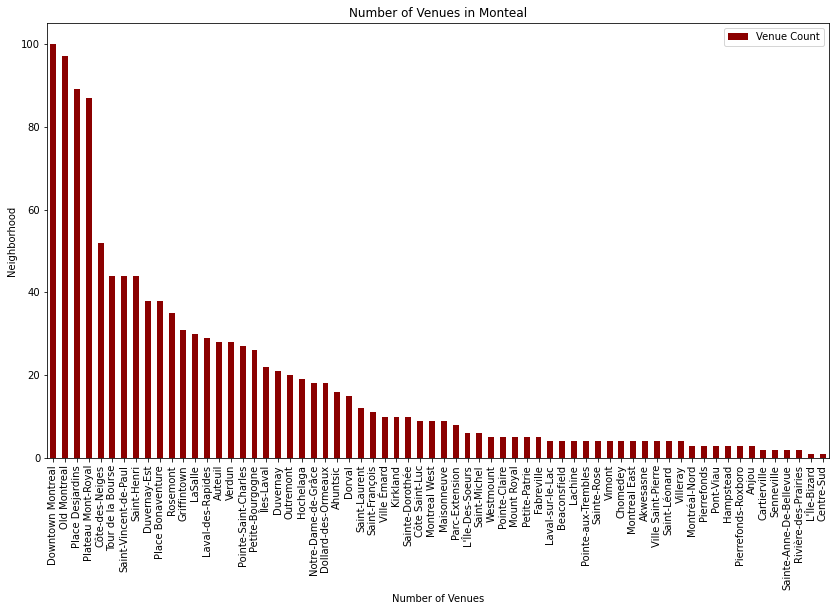

In [18]:
venue_count_neigh_for_plot = venue_count_neigh.set_index('Neighborhood')

venue_count_neigh_for_plot.plot(kind='bar', figsize=(14, 8), color='darkred')

plt.xlabel('Number of Venues') # add to x-label to the plot
plt.ylabel('Neighborhood') # add y-label to the plot
plt.title('Number of Venues in Monteal') # add title to the plot

plt.show()

Let's find out how many unique categories can be curated from all the returned venues

In [19]:
print('There are {} uniques categories.'.format(len(montreal_venues['Venue Category'].unique())))

There are 206 uniques categories.


### 4.3 Analyze Each Neighborhood

In [20]:
# one hot encoding
montreal_onehot = pd.get_dummies(montreal_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
montreal_onehot['Neighborhood'] = montreal_venues['Neighborhood'] 

# move neighborhood column to the first column
neighborhood_column = montreal_onehot.columns.get_loc('Neighborhood')

fixed_columns = [montreal_onehot.columns[neighborhood_column]] + list(montreal_onehot.columns[:neighborhood_column]) + list(montreal_onehot.columns[neighborhood_column+1:])
montreal_onehot = montreal_onehot[fixed_columns]

montreal_onehot.head()

,Neighborhood,Accessories Store,American Restaurant,Arcade,Art Gallery,Art Museum,Asian Restaurant,Athletics & Sports,BBQ Joint,Bakery,Bank,Bar,Beer Store,Big Box Store,Bike Rental / Bike Share,Bistro,Bookstore,Boutique,Boxing Gym,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Café,Cambodian Restaurant,Candy Store,Caribbean Restaurant,Casino,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Football Field,Comedy Club,Comfort Food Restaurant,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Dog Run,Drugstore,Dumpling Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Escape Room,Event Space,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Gas Station,Gastropub,German Restaurant,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Halal Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health Food Store,Historic Site,History Museum,Hockey Arena,Home Service,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Karaoke Bar,Korean Restaurant,Liquor Store,Lounge,Mac & Cheese Joint,Malay Restaurant,Market,Massage Studio,Mattress Store,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mongolian Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Museum,Music Venue,Nail Salon,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Paper / Office Supplies Store,Park,Pastry Shop,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Café,Pet Store,Pharmacy,Pie Shop,Pizza Place,Playground,Plaza,Polish Restaurant,Pool,Portuguese Restaurant,Post Office,Print Shop,Pub,Public Art,Ramen Restaurant,Record Shop,Recreation Center,Rental Car Location,Residential Building (Apartment / Condo),Restaurant,Russian Restaurant,Salad Place,Salvadoran Restaurant,Sandwich Place,Scenic Lookout,Seafood Restaurant,Shabu-Shabu Restaurant,Shoe Store,Shopping Mall,Shopping Plaza,Skating Rink,Soccer Field,South American Restaurant,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Steakhouse,Supermarket,Sushi Restaurant,Swiss Restaurant,Taco Place,Tapas Restaurant,Tea Room,Tennis Court,Tex-Mex Restaurant,Thai Restaurant,Theater,Thrift / Vintage Store,Toy / Game Store,Trail,Train,Train Station,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wine Bar,Women's Store,Yoga Studio
0,Pointe-aux-Trembles,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Pointe-aux-Trembles,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Pointe-aux-Trembles,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

#### Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category
As shown from the bar graph, there are a couple of neighborhoods where the number of venues are low. This means that the those neighborhoods are suburb areas. For the purpose of the analysis, those neighborhoods will be ignored.

In [21]:
# Create dataframe where the neighborhood have more than 10 venues 
venue_count_more10_neigh = venue_count_neigh.loc[venue_count_neigh['Venue Count'] > 10, ['Neighborhood']]
#venue_count_less10_neigh.head()
#venue_count_more10_neigh.shape

montreal_grouped = montreal_onehot.groupby('Neighborhood').mean().reset_index()
montreal_grouped

montreal_grouped_adj = pd.merge(montreal_grouped, venue_count_more10_neigh, how='inner', on='Neighborhood')

montreal_grouped_adj.head()
#montreal_grouped_adj.shape

,Neighborhood,Accessories Store,American Restaurant,Arcade,Art Gallery,Art Museum,Asian Restaurant,Athletics & Sports,BBQ Joint,Bakery,Bank,Bar,Beer Store,Big Box Store,Bike Rental / Bike Share,Bistro,Bookstore,Boutique,Boxing Gym,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Café,Cambodian Restaurant,Candy Store,Caribbean Restaurant,Casino,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Football Field,Comedy Club,Comfort Food Restaurant,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Dog Run,Drugstore,Dumpling Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Escape Room,Event Space,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Gas Station,Gastropub,German Restaurant,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Halal Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health Food Store,Historic Site,History Museum,Hockey Arena,Home Service,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Karaoke Bar,Korean Restaurant,Liquor Store,Lounge,Mac & Cheese Joint,Malay Restaurant,Market,Massage Studio,Mattress Store,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mongolian Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Museum,Music Venue,Nail Salon,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Paper / Office Supplies Store,Park,Pastry Shop,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Café,Pet Store,Pharmacy,Pie Shop,Pizza Place,Playground,Plaza,Polish Restaurant,Pool,Portuguese Restaurant,Post Office,Print Shop,Pub,Public Art,Ramen Restaurant,Record Shop,Recreation Center,Rental Car Location,Residential Building (Apartment / Condo),Restaurant,Russian Restaurant,Salad Place,Salvadoran Restaurant,Sandwich Place,Scenic Lookout,Seafood Restaurant,Shabu-Shabu Restaurant,Shoe Store,Shopping Mall,Shopping Plaza,Skating Rink,Soccer Field,South American Restaurant,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Steakhouse,Supermarket,Sushi Restaurant,Swiss Restaurant,Taco Place,Tapas Restaurant,Tea Room,Tennis Court,Tex-Mex Restaurant,Thai Restaurant,Theater,Thrift / Vintage Store,Toy / Game Store,Trail,Train,Train Station,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wine Bar,Women's Store,Yoga Studio
0,Ahuntsic,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.062500,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.125000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.062500,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.062500,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.062500,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0625,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0625,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.062500,0.0,0.0,0.000000,0.000000,0.0,0.0,0.062500,0.0,0.000000,0.0,0.0625,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.187500,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,

#### Let's put that into a pandas dataframe

Let's put that into a pandas dataframe

In [22]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Now let's create the new dataframe and display the top 10 venues for each neighborhood.

In [23]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = montreal_grouped_adj['Neighborhood']

for ind in np.arange(montreal_grouped_adj.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(montreal_grouped_adj.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Ahuntsic,Restaurant,Café,Park,Breakfast Spot,Coffee Shop,Fast Food Restaurant,Tea Room,Ice Cream Shop,Pharmacy,Gastropub
1,Auteuil,Breakfast Spot,Grocery Store,Indian Restaurant,Pizza Place,Food,Tea Room,Sandwich Place,Fish & Chips Shop,Café,French Restaurant
2,Côte-des-Neiges,Coffee Shop,Middle Eastern Restaurant,Fast Food Restaurant,Bookstore,Vietnamese Restaurant,Farmers Market,Restaurant,Bakery,Café,Bar
3,Dollard-des-Ormeaux,Skating Rink,Italian Restaurant,Thai Restaurant,Fast Food Restaurant,Shopping Mall,Food & Drink Shop,Restaurant,Burger Joint,Park,Mexican Restaurant
4,Dorval,Hotel,Gas Station,Bank,Sandwich Place,Rental Car Location,Recreation Center,Sushi Restaurant,Coffee Shop,Bar,Fast Food Restaurant


### Cluster Neighborhoods
In this section, the neighborhoods in Montreal will be classified into groups using **K-Means Clustering**. Before, building the model, the optimum k will be determined. Elbow method is one of the most popular method to determine the optimal k (number of clusters). 
There are two metric used in the Elbow method:
- Distortion: The average of the squared distances from the cluster centers of the respective clusters. Typically, the Euclidean distance metric is used.
- Inertia: It is the sum of squared distances of data to their closest cluster center.

In [24]:
montreal_grouped_adj_clustering = montreal_grouped_adj.drop('Neighborhood', 1)

distortions_Euclidean  = [] 
distortions_Canberra   = [] 
inertias = [] 
K = range(1,10) 
  
for k in K: 
    #Building and fitting the model 
    kmeanModel = KMeans(n_clusters=k, random_state=0).fit(montreal_grouped_adj_clustering)   
      
    distortions_Euclidean.append(sum(np.min(cdist(montreal_grouped_adj_clustering, kmeanModel.cluster_centers_, 
                      'euclidean'),axis=1)) / montreal_grouped_adj_clustering.shape[0]) 
    distortions_Canberra.append(sum(np.min(cdist(montreal_grouped_adj_clustering, kmeanModel.cluster_centers_, 
                      'canberra'),axis=1)) / montreal_grouped_adj_clustering.shape[0]) 
    inertias.append(kmeanModel.inertia_) 

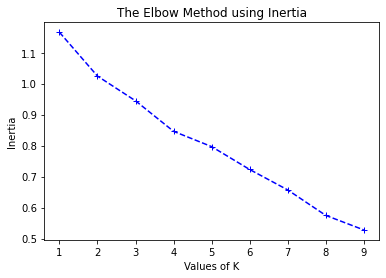

In [25]:
# Plot the elbow using Inertia
plt.plot(K, inertias, 'b+--') 
plt.xlabel('Values of K') 
plt.ylabel('Inertia') 
plt.title('The Elbow Method using Inertia') 
plt.show() 

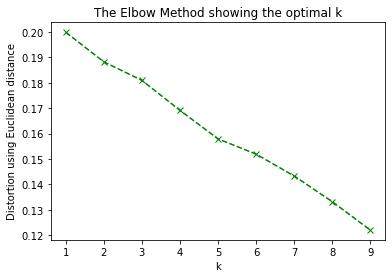

In [26]:
# Plot the elbow using Distortion with Euclidean distance
plt.plot(K, distortions_Euclidean, 'gx--')
plt.xlabel('k')
plt.ylabel('Distortion using Euclidean distance')
plt.title('The Elbow Method showing the optimal k')
plt.show()

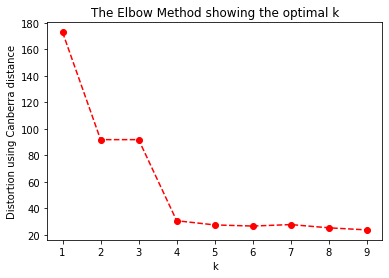

In [27]:
# Plot the elbow using Distortion with Canberra distance
plt.plot(K, distortions_Canberra, 'ro--')
plt.xlabel('k')
plt.ylabel('Distortion using Canberra distance')
plt.title('The Elbow Method showing the optimal k')
plt.show()

To determine the optimal number of clusters, we have to select the value of k at the “elbow” (i.e. the point after which the distortion/inertia start decreasing in a linear fashion). From the graphs above, using Distortion with Euclidean distance and Inertia, the optimal k is not obvious. However, using Distortion with Canberra distance, we see a clear evidence that the optimal number of clusters for the data is 4. 

In [28]:
# set optimal number of clusters
kclusters = 4

# run k-means clustering
kmeans_optimal = KMeans(n_clusters=kclusters, random_state=0).fit(montreal_grouped_adj_clustering)

# check cluster labels generated for each row in the dataframe
kmeans_optimal.labels_[0:10] 

array([3, 3, 0, 3, 1, 1, 0, 1, 1, 0], dtype=int32)

Let's create a new dataframe that contains the top 10 venues for each cluster.

In [29]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans_optimal.labels_)
montreal_merged = df_mtl_neigh_LongLat
# merge montreal_merged with manhattan_data to add latitude/longitude for each neighborhood
montreal_merged = montreal_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), how='inner', on='Neighborhood')
montreal_merged.reset_index(drop=True, inplace=True)

montreal_merged.head() # check the last columns!

,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Downtown Montreal,45.505290,-73.564076,1,Hotel,Café,Asian Restaurant,Plaza,French Restaurant,Performing Arts Venue,Japanese Restaurant,Restaurant,Art Museum,Hawaiian Restaurant
1,Notre-Dame-de-Grâce,45.467967,-73.628922,3,Café,Grocery Store,Pizza Place,Mexican Restaurant,Mac & Cheese Joint,Sporting Goods Shop,Post Office,Sandwich Place,Tea Room,Park
2,Place Bonaventure,45.499583,-73.564917,1,Coffee Shop,Hotel,French Restaurant,Restaurant,Plaza,Café,Breakfast Spot,Building,Burger Joint,Japanese Restaurant
3,Duvernay-Est,45.499583,-73.564917,1,Coffee Shop,Hotel,French Restaurant,Restaurant,Plaza,Café,Breakfast Spot,Building,Burger Joint,Japanese Restaurant
4,Dollard-des-Ormeaux,45.484230,-73.806455,3,Skating Rink,Italian Restaurant,Thai Restaurant,Fast Food Restaurant,Shopping Mall,Food & Drink Shop,Restaurant,Burger Joint,Park,Mexican Restaurant


Let's visualize the resulting clusters

In [30]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(montreal_merged['Latitude'], montreal_merged['Longitude'], montreal_merged['Neighborhood'], montreal_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

Let's the number of 1st most common venues for by cluster. This will allow us to assign a name for each cluster

In [31]:
montreal_venue_count = montreal_merged.groupby(by=['Cluster Labels', '1st Most Common Venue']).count()

montreal_venue_count= montreal_venue_count.iloc[:,0:1]

montreal_venue_count.rename(columns={"Neighborhood": "Count"}, inplace = True)

montreal_venue_count.reset_index(inplace = True)

montreal_venue_count.set_index('1st Most Common Venue', inplace = True)

montreal_venue_count

,Cluster Labels,Count
1st Most Common Venue,,
Café,0,2
Coffee Shop,0,2
Fast Food Restaurant,0,1
Hockey Arena,0,1
Pharmacy,0,1
Pizza Place,0,2
Chinese Restaurant,1,1
Coffee Shop,1,2
French Restaurant,1,1


In [32]:
def graph_cluster(cluster, color):
    
    montreal_venue_count[['Count']][montreal_venue_count['Cluster Labels'] == cluster].sort_values('Count',ascending=False).plot(kind='bar', figsize=(6, 6), color = color)

    plt.xlabel('Categroy of Venues') # add to x-label to the plot
    plt.ylabel('Number of Venues') # add y-label to the plot
    plt.title('Number of Venues in Cluster ' + str(cluster)) # add title to the plot

    plt.show()


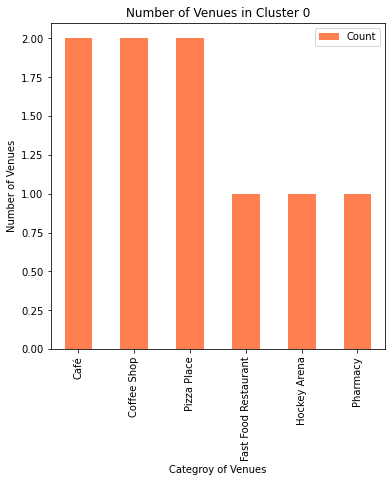

In [33]:
graph_cluster(0,'coral')

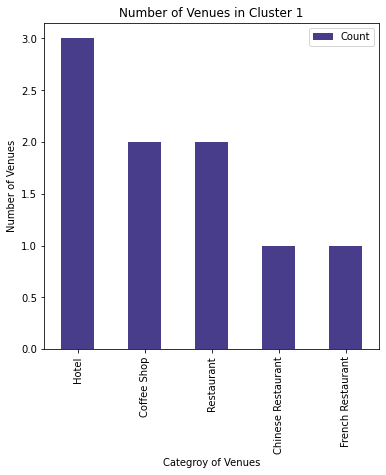

In [34]:
graph_cluster(1,'darkslateblue')

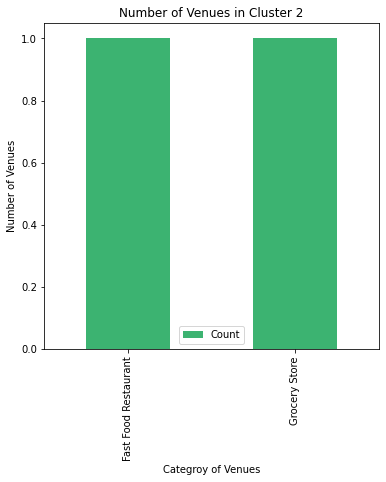

In [35]:
graph_cluster(2,'mediumseagreen')

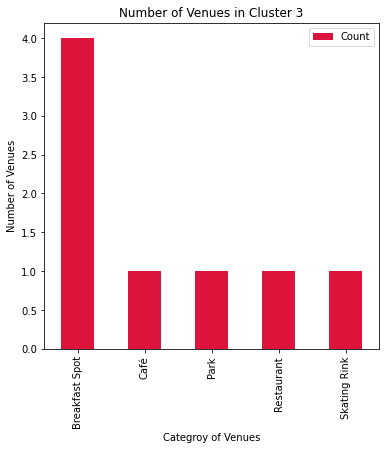

In [36]:
graph_cluster(3,'crimson')

When examining graphs above, a name is assigned to each cluster:

- Cluster 0 : Café/Coffee Shop/Pizza Place Venues
- Cluster 1 : Hotel Venues
- Cluster 2 : Fast Food Restaurant/Grocery Store Venues
- Cluster 3 : Breakfast Spot Venues

In [37]:
label_name = pd.DataFrame({"Cluster" : [0, 1, 2, 3], "Name" : ['Café/Coffee Shop/Pizza Place Venues', 'Hotel Venues', 'Fast Food Restaurant/Grocery Store Venues', 'Breakfast Spot Venues']})
cluster_name = pd.DataFrame(data=label_name)
cluster_name

,Cluster,Name
0,0,Café/Coffee Shop/Pizza Place Venues
1,1,Hotel Venues
2,2,Fast Food Restaurant/Grocery Store Venues
3,3,Breakfast Spot Venues


### Cluster Neighborhoods

Cluster 0

In [38]:
montreal_merged.loc[montreal_merged['Cluster Labels'] == 0, montreal_merged.columns[[0] + list(range(4, montreal_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
11,Duvernay,Coffee Shop,Café,Yoga Studio,Bar,Pharmacy,Pastry Shop,Park,Pool,Dog Run,French Restaurant
13,Plateau Mont-Royal,Café,French Restaurant,Bakery,Bar,Portuguese Restaurant,Coffee Shop,Bookstore,Burger Joint,Health Food Store,Sushi Restaurant
16,Pointe-Saint-Charles,Pizza Place,Bar,Cocktail Bar,Café,Gym,Restaurant,Indian Restaurant,Coffee Shop,Sports Bar,Sushi Restaurant
18,Laval-des-Rapides,Hockey Arena,Furniture / Home Store,Coffee Shop,Concert Hall,Yoga Studio,College Football Field,Bus Station,Shopping Mall,Sandwich Place,Restaurant
19,LaSalle,Fast Food Restaurant,Pet Store,Pharmacy,Coffee Shop,Bank,Italian Restaurant,Indian Restaurant,Chinese Restaurant,Café,Shopping Mall
21,Côte-des-Neiges,Coffee Shop,Middle Eastern Restaurant,Fast Food Restaurant,Bookstore,Vietnamese Restaurant,Farmers Market,Restaurant,Bakery,Café,Bar
22,Rosemont,Café,Coffee Shop,Bar,Restaurant,Clothing Store,Portuguese Restaurant,Climbing Gym,Print Shop,Pizza Place,Supermarket
24,Hochelaga,Pizza Place,Tex-Mex Restaurant,Bus Stop,Shopping Plaza,Skating Rink,Dive Bar,Fruit & Vegetable Store,Coffee Shop,Taco Place,Ice Cream Shop
26,Îles-Laval,Pharmacy,Vietnamese Restaurant,Italian Restaurant,Halal Restaurant,Sushi Restaurant,Cosmetics Shop,Dessert Shop,Portuguese Restaurant,Coffee Shop,Casino


Cluster 1

In [39]:
montreal_merged.loc[montreal_merged['Cluster Labels'] == 1, montreal_merged.columns[[0] + list(range(4, montreal_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Downtown Montreal,Hotel,Café,Asian Restaurant,Plaza,French Restaurant,Performing Arts Venue,Japanese Restaurant,Restaurant,Art Museum,Hawaiian Restaurant
2,Place Bonaventure,Coffee Shop,Hotel,French Restaurant,Restaurant,Plaza,Café,Breakfast Spot,Building,Burger Joint,Japanese Restaurant
3,Duvernay-Est,Coffee Shop,Hotel,French Restaurant,Restaurant,Plaza,Café,Breakfast Spot,Building,Burger Joint,Japanese Restaurant
6,Place Desjardins,Chinese Restaurant,Hotel,Vietnamese Restaurant,Asian Restaurant,Concert Hall,Restaurant,Café,Breakfast Spot,French Restaurant,Vegetarian / Vegan Restaurant
8,Griffintown,Restaurant,Italian Restaurant,Sushi Restaurant,Brewery,Gym / Fitness Center,Pharmacy,Pie Shop,Climbing Gym,Pub,Middle Eastern Restaurant
15,Petite-Bourgogne,Restaurant,Italian Restaurant,French Restaurant,BBQ Joint,Sushi Restaurant,Fried Chicken Joint,Pub,Event Space,Gas Station,Gastropub
20,Dorval,Hotel,Gas Station,Bank,Sandwich Place,Rental Car Location,Recreation Center,Sushi Restaurant,Coffee Shop,Bar,Fast Food Restaurant
25,Old Montreal,Hotel,French Restaurant,Café,Restaurant,Italian Restaurant,Sandwich Place,Coffee Shop,Asian Restaurant,Plaza,Lounge
27,Tour de la Bourse,French Restaurant,Hotel,Café,Restaurant,Portuguese Restaurant,Sandwich Place,Coffee Shop,Plaza,Burrito Place,Burger Joint


Cluster 2

In [40]:
montreal_merged.loc[montreal_merged['Cluster Labels'] == 2, montreal_merged.columns[[0] + list(range(4, montreal_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
7,Saint-François,Fast Food Restaurant,Restaurant,Grocery Store,Pharmacy,Food Truck,Gym / Fitness Center,Liquor Store,Bakery,Bank,English Restaurant
17,Saint-Laurent,Grocery Store,Bank,Accessories Store,Coffee Shop,Restaurant,Fast Food Restaurant,Beer Store,Indian Restaurant,Pharmacy,Vietnamese Restaurant


Cluster 3

In [41]:
montreal_merged.loc[montreal_merged['Cluster Labels'] == 3, montreal_merged.columns[[0] + list(range(4, montreal_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Notre-Dame-de-Grâce,Café,Grocery Store,Pizza Place,Mexican Restaurant,Mac & Cheese Joint,Sporting Goods Shop,Post Office,Sandwich Place,Tea Room,Park
4,Dollard-des-Ormeaux,Skating Rink,Italian Restaurant,Thai Restaurant,Fast Food Restaurant,Shopping Mall,Food & Drink Shop,Restaurant,Burger Joint,Park,Mexican Restaurant
5,Ahuntsic,Restaurant,Café,Park,Breakfast Spot,Coffee Shop,Fast Food Restaurant,Tea Room,Ice Cream Shop,Pharmacy,Gastropub
9,Saint-Henri,Breakfast Spot,Grocery Store,Ice Cream Shop,Café,Restaurant,Bakery,Mexican Restaurant,Middle Eastern Restaurant,Art Gallery,Coffee Shop
10,Saint-Vincent-de-Paul,Breakfast Spot,Grocery Store,Ice Cream Shop,Café,Restaurant,Bakery,Mexican Restaurant,Middle Eastern Restaurant,Art Gallery,Coffee Shop
12,Verdun,Breakfast Spot,Grocery Store,Indian Restaurant,Pizza Place,Food,Tea Room,Sandwich Place,Fish & Chips Shop,Café,French Restaurant
14,Auteuil,Breakfast Spot,Grocery Store,Indian Restaurant,Pizza Place,Food,Tea Room,Sandwich Place,Fish & Chips Shop,Café,French Restaurant
23,Outremont,Park,Italian Restaurant,Bakery,Restaurant,Café,Ice Cream Shop,Tea Room,Theater,Thai Restaurant,Gourmet Shop
